In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Video Frame Extraction

In [ ]:
%ls /content/drive/MyDrive/clm/

In [ ]:
import os
import cv2

# folder containing the videos
folder = "/content/drive/MyDrive/clm/"

# subfolder to save the frames
subfolder = "frames"

# create the subfolder if it doesn't exist
if not os.path.exists(os.path.join(folder, subfolder)):
    os.makedirs(os.path.join(folder, subfolder))

# loop through all the files in the folder
for filename in os.listdir(folder):
    # check if file is a video
    if filename.endswith(".mov") or filename.endswith(".MOV") or filename.endswith(".MP4"):
        # get the video name
        video_name = os.path.splitext(filename)[0]
        # create a video capture object
        cap = cv2.VideoCapture(os.path.join(folder, filename))
        # get the fps of the video
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_counter = 0
        # loop through the video frames
        while True:
            ret, frame = cap.read()
            # check if we have reached the end of the video
            if not ret:
                break
            # check if we need to extract the frame
            if cap.get(cv2.CAP_PROP_POS_FRAMES) % (fps * 5) == 0:
                # save the frame to a file
                cv2.imwrite(os.path.join(folder, subfolder, "{}_frame_{}.jpg".format(video_name, frame_counter)), frame)
                frame_counter+=1
        # release the video capture object
        cap.release()

In [ ]:
import os
import cv2

# folder containing the images
folder = "/content/drive/MyDrive/clm/frames/"

# loop through all the files in the folder
for filename in os.listdir(folder):
    # check if file is an image
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # read the image
        img = cv2.imread(os.path.join(folder, filename))
        # flip the image vertically
        img_flip = cv2.flip(img, 0)
        # save the flipped image
        cv2.imwrite(os.path.join(folder, filename), img_flip)

# YOLO Label Conversion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/clm/clm_v1

/content/drive/MyDrive/clm/clm_v1


In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            #image_size = [640, 360, 3]
            image_size = []
            for subelem in elem:
               image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
import math
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {'person':0, 'hold':1,
                           }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
          class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
          print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save 
    save_file_name = os.path.join("labels", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
import os
import tqdm
import xml.etree.ElementTree as ET

# Get the annotations
labels = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "xml"]
labels.sort()

# Convert and save the annotations
for ann in labels:
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
labels = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

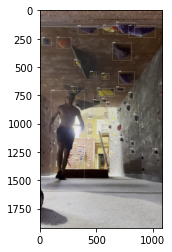

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
import cv2
import numpy as np
random.seed(1)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(labels)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
from sklearn.model_selection import train_test_split# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
labels = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

images.sort()
labels.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.2, random_state = 1)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size = 0.3, random_state = 1)

In [ ]:
!mkdir images/train images/val images/test labels/train labels/val labels/test

In [ ]:
#Utility function to move images 
import shutil
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_labels, 'labels/train/')
move_files_to_folder(val_labels, 'labels/val/')
move_files_to_folder(test_labels, 'labels/test/')

#RENAME THE ANNOTATIONS DIR TO LABELS!!!

# YOLOv8 Training and Inference

In [ ]:
%cd /content/drive/MyDrive/

In [ ]:
!pip install ultralytics
!pip install hydra
#!git clone https://github.com/ultralytics/ultralytics.git

%cd /content/drive/MyDrive/ultralytics
!pip install -e ultralytics

from IPython import display
display.clear_output()
!yolo checks

In [ ]:
!yolo task=detect mode=train model=yolov8m.pt data='/content/drive/MyDrive/clm/clm.yaml' epochs=100 imgsz=640

In [ ]:
!yolo task=detect mode=predict save=True model=/content/drive/MyDrive/ultralytics/runs/detect/train4/weights/best.pt conf=0.5 source=/content/drive/MyDrive/clm/clm_v1/images/test/ line_thickness=2

In [ ]:
!yolo task=detect mode=predict save=True model=/content/drive/MyDrive/ultralytics/runs/detect/train4/weights/best.pt hide_labels=True hide_conf=True iou=0.6 conf=0.7 source=/content/drive/MyDrive/clm/vids/ line_thickness=1

# Output Conversion

In [ ]:
!pip install imageio==2.4.1

In [ ]:
import subprocess
import os

folder = "/content/drive/MyDrive/ultralytics/runs/detect/predict8/"

for filename in os.listdir(folder):
    if filename.endswith(".mp4"):
        original_file = os.path.join(folder, filename)
        re_encoded_file = os.path.join(folder, "re_encoded_" + filename)
        subprocess.run(['ffmpeg', '-i', original_file, '-c:v', 'libx264', '-crf', '20', '-c:a', 'aac', '-b:a', '192k', re_encoded_file])

In [ ]:
import re
import subprocess
original_audio = '/content/drive/MyDrive/clm/lofi.mp3'
re_encoded_audio = '/content/drive/MyDrive/clm/lofi.aac'
subprocess.run(['ffmpeg', '-i', original_audio, '-c:a', 'aac', '-b:a', '192k', '-strict', '-2', re_encoded_audio])

In [ ]:
import cv2
from moviepy.editor import *
import os

# Folder containing the videos
folder = "/content/drive/MyDrive/ultralytics/runs/detect/predict8/"

# Audio file to be used
audio = AudioFileClip("/content/drive/MyDrive/clm/lofi.aac")
audio_duration = audio.duration
i=0
# Add audio to videos
for filename in os.listdir(folder):
    if filename.endswith(".mp4"):
        video = VideoFileClip(os.path.join(folder, filename))

        # Flip video vertically
        video = video.fx(vfx.mirror_y)

        # Get the duration of the video
        video_duration = video.duration

        # Get the starting point of the audio for the current video
        start = audio_duration * (i / len(os.listdir(folder)))
        i = i + 1

        # Get the audio clip for the current video
        audio_clip = audio.subclip(start, start + video_duration)

        # Add audio to the video
        video = video.set_audio(audio_clip)

        # Save the modified video
        video.write_videofile("/content/drive/MyDrive/clm/final_out_2/" + filename)